[View in Colaboratory](https://colab.research.google.com/github/pedro00dk/python-lml/blob/master/tensorflow.ipynb)

# TensorFlow

This notebook contains my progress studing the TensorFlow library.


### Resources
* https://www.tensorflow.org/guide/
* https://www.tensorflow.org/api_docs/
* https://learningtensorflow.com/getting_started/


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import tensorflow as tf

## Basics

Tensorflow has two main components, they are:
* `tf.Graph`: Builds the computational graph;
* `tf.Session`,: Runs the computational graph.

### The Computational Graph: `tf.Graph`

A computational graph is a series of TensorFlow operations, organized in a graph, and this graph is made by two elements:
* `tf.Operation`: Operations are the nodes of the graph, these elements produce and consume Tensors.
* `tf.Tensor`: Tensors are the edges of the graph, they represent the values flow over the graph, but they do not store any value.

*Most of TensorFlow operations create an Operation (graph node) and returns its output Tensor (node output edge), the operation node can be accessed through *`tensor.op`* property of the output Tensor*


The most simple element in TensorFlow is a `tf.constant`, it represents a simple operation that does not take any tensor as input but the input passed as argument.


In [2]:
a = tf.constant(3.0, dtype=tf.float32)
b = tf.constant(4.0) # also tf.float32 implicitly

# c = tf.add(a, b) # this is an alias to tf.math.add
c = a + b # plus operator implements the previous line

print('Operations -> a:', repr(a.op), ', b:', repr(b.op), ', c:', repr(c.op))
print('Tensors -> a:', a, ', b:', b, ', c:', c)
print(a.graph, b.graph, c.graph)
print(tf.get_default_graph())

Operations -> a: <tf.Operation 'Const' type=Const> , b: <tf.Operation 'Const_1' type=Const> , c: <tf.Operation 'add' type=Add>
Tensors -> a: Tensor("Const:0", shape=(), dtype=float32) , b: Tensor("Const_1:0", shape=(), dtype=float32) , c: Tensor("add:0", shape=(), dtype=float32)
<tensorflow.python.framework.ops.Graph object at 0x7f9daa7e9400> <tensorflow.python.framework.ops.Graph object at 0x7f9daa7e9400> <tensorflow.python.framework.ops.Graph object at 0x7f9daa7e9400>


The code above does not output the expected result `7.0`,  it only builds the computation graph where the Tensors represents the output of the operations that will be run.

As we can see, `a` and `b` variables are output Tensors of the `const` operation. When we sum these variables, the result is also a new output Tensor for a new `add` operation, the created `add` operation took the `a` and `b` tensors as input, they should have the same type. The add output tensor has the same type of `a` and `b`.

The Operations and Tensors receive an unique name, this name is not correlated with the python variables names. Operations names starts with the operation type folowed by an unique incremental index e. g. `Const_1`, the output tensor of this operation contains the operation name folowed by it's output index (an operation can output more than one Tensor) e. g. `Const_1:0`.

`a`, `b` and `c` are inside the same graph, the tensorflow default graph, it also can be accessed through `tf.get_default_graph()`.

### The Executor: `tf.Session`

The session is responsible for running the computational graph and return to the user the result of the selected tensors. Assesion can be initialized with the `tf.Session` function. When the session receives a request to compute the output of a Tensor through the `tf.Session.run` method, TensorFlow navigates backwards in the graph to find all nodes that provide some input and then starts the computation.

The function `tf.Session.run` can receive a single tensor to get the output, or a combination of tuples, lists and tuples with tensors as values, a structure with the same layout will be returned with the tensors results.

In [3]:
session = tf.Session()
print(session.run(c))
print(session.run({'constants in tuple': (a, b), 'constants in list': [a, b], 'constants in dict': {'a': a, 'b':b}, 'add': c}))

7.0
{'constants in tuple': (3.0, 4.0), 'constants in list': [3.0, 4.0], 'constants in dict': {'a': 3.0, 'b': 4.0}, 'add': 7.0}


Each call to `tf.Session.run` gets an unique value of the input operations, **if a tensor is accessed more than once in the same run call, it  will always produce the same output value. But in different run calls it may produce different values.**
An example is `tr.random_uniform`, it's value is computed every `tf.Session.run` call, but if it's accessed twice in the same run call, its value will not be recomputed.

In [4]:
rand_vec = tf.random_uniform(shape=(3,))

print('different run calls: ', session.run(rand_vec), session.run(rand_vec))
print('same run call: ', session.run((rand_vec, rand_vec)))
print('same run call (derivated tensors): ', session.run((rand_vec + 1, rand_vec + 2)))

different run calls:  [0.14626276 0.61317956 0.04802644] [0.7488172  0.6997881  0.03841913]
same run call:  (array([0.15951204, 0.61535764, 0.35622692], dtype=float32), array([0.15951204, 0.61535764, 0.35622692], dtype=float32))
same run call (derivated tensors):  (array([1.7698046, 1.1879358, 1.207135 ], dtype=float32), array([2.7698045, 2.1879358, 2.207135 ], dtype=float32))


Session should be closed to release resources through the method `tf.Session.close`. `tf.Session` also implements the methods `__enter__` and `__exit__`, making the use of python's `with` keyword available.

In [0]:
session.close()

with tf.Session() as session:
    pass

### Feeding

The graphs that we saw are not very useful because they always produce the same result,. A graph can be parametrized, it means the value of some of its input nodes can be provided later (accepting external input), these nodes are known as placeholders and can be created with the `tf.placeholder` function.

In [6]:
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
c = a + b

print('Operations -> a:', repr(a.op), ', b:', repr(b.op), ', c:', repr(c.op))
print('Tensors -> a:', a, ', b:', b, ', c:', c)

Operations -> a: <tf.Operation 'Placeholder' type=Placeholder> , b: <tf.Operation 'Placeholder_1' type=Placeholder> , c: <tf.Operation 'add_3' type=Add>
Tensors -> a: Tensor("Placeholder:0", dtype=float32) , b: Tensor("Placeholder_1:0", dtype=float32) , c: Tensor("add_3:0", dtype=float32)


The code above produced two `tf.placeholder` operations and tensors.

The placeholders values should be provided in the `tf.Session.run` call, the parameter **`feed_dict`**, receives a dict with the placeholders objects as keys and the placeholder assigned value as value, the value may be a single element but can be any iterable too, in this case, if there are more than one placeholder, those values shall have the same dimension, and in every dimension, the children shall have the same shape.

In [7]:
with tf.Session() as session:
    print(session.run(c, feed_dict={a: 3, b: 4.5}))
    print(session.run(c, feed_dict={a: [1, 3], b: [2, 4]}))
    print(session.run(c, feed_dict={a: [[[1, 2], [3, 4]], [[1, 2],[1, 2]]], b: [[[4, 3], [2, 1]], [[2, 1], [1, 2]]]}))

7.5
[3. 7.]
[[[5. 5.]
  [5. 5.]]

 [[3. 3.]
  [2. 4.]]]


### Datasets and Iterators

TensorFlow placeholders as useful for small experiments and maybe some graph parameters, but according to TensorFlow's website, `tf.data` is the prefered method of streaming data to a model.

The `tf.data.Dataset.from_tensor_slices` creates a dataset from the received data, where the elements are the slices ate the 0th dimension of the received data, the elements shall have the same shape (dense vector).

`tf.data.Dataset.make_one_shot_iterator` and `tf.data.Dataset.make_initializable_iterator` provide an `tf.data.Iterator` of the dataset slices. There are other types of ways to initialize an iterator thar provides iterators with different properties.

In [8]:
data = [
    [0, 1],
    [2, 3],
    [4, 5],
    [6, 7]
]
dataset = tf.data.Dataset.from_tensor_slices(data)

# datasets also can be initialized from a tensor too, including placeholders
# dataset = tf.data.Dataset.from_tensor_slices(tf.constant(data))

iterator = dataset.make_one_shot_iterator()

print(dataset, iterator)

<TensorSliceDataset shapes: (2,), types: tf.int32> <tensorflow.python.data.ops.iterator_ops.Iterator object at 0x7f9daa83ff60>


The tensorflow iterator doesnot work like other iterators, you need to produce only the first element, each consecutive call to `tf.Session.run` requiring the tensor generated by the first `tf.data.Iterator.get_next` call will provide the next slice element from the dataset. If the slice tensor is required more than once in a single `tf.Session.run` call, the values will not be updated.

In [9]:
slice = iterator.get_next()
print(slice)

with tf.Session() as session:
    try:
        # while True: print(session.run(slice))
        while True: print(session.run((slice, slice))) # using the tensor twice produces the same result
    except tf.errors.OutOfRangeError as e:
        pass

Tensor("IteratorGetNext:0", shape=(2,), dtype=int32)
(array([0, 1], dtype=int32), array([0, 1], dtype=int32))
(array([2, 3], dtype=int32), array([2, 3], dtype=int32))
(array([4, 5], dtype=int32), array([4, 5], dtype=int32))
(array([6, 7], dtype=int32), array([6, 7], dtype=int32))


One shot iterators are not reusable, but it's possible to create a reusable iterator for the same dataset with the `tf.data.Dataset.make_initializable_iterator`, this method returns an unitialized iterator that shall be initialized by the session using the `tf.data.Iterator.initializer` property. The `tf.data.Iterator.initializer` can be used to initialize the iterator as many times it is nescessary.

In [10]:
data = [
    [0, 1],
    [2, 3],
    [4, 5],
    [6, 7]
]
dataset = tf.data.Dataset.from_tensor_slices(data)
iterator = dataset.make_initializable_iterator()

print(dataset, iterator)

slice = iterator.get_next()
print(slice)

with tf.Session() as session:
    session.run(iterator.initializer) # initializes the iterator
    try:
        while True: print(session.run(slice), end=' ')
    except tf.errors.OutOfRangeError as e:
        pass

<TensorSliceDataset shapes: (2,), types: tf.int32> <tensorflow.python.data.ops.iterator_ops.Iterator object at 0x7f9da6684cf8>
Tensor("IteratorGetNext_1:0", shape=(2,), dtype=int32)
[0 1] [2 3] [4 5] [6 7] 

Combine iterators and placeholders is a good strategy to use new data for different `tf.Session.run` calls.

In [11]:
data_0 = [0, 1, 2, 3]
data_1 = [4, 5, 6, 7]

placeholder = tf.placeholder(tf.float32)
dataset = tf.data.Dataset.from_tensor_slices(placeholder)
iterator = dataset.make_initializable_iterator()

print(dataset, iterator)

with tf.Session() as session:

    print('first session')
    session.run(iterator.initializer, feed_dict={placeholder: data_0}) # initializes the iterator using the placeholder data
    slice = iterator.get_next()
    try:
        while True: print(session.run(slice), end=' ')
    except tf.errors.OutOfRangeError as e:
        pass
    print()

    print('second session')
    session.run(iterator.initializer, feed_dict={placeholder: data_1}) # initializes the iterator using the placeholder data, again
    slice = iterator.get_next()
    try:
        while True: print(session.run(slice), end=' ')
    except tf.errors.OutOfRangeError as e:
        pass
    print()

<TensorSliceDataset shapes: <unknown>, types: tf.float32> <tensorflow.python.data.ops.iterator_ops.Iterator object at 0x7f9dd6826860>
first session
0.0 1.0 2.0 3.0 
second session
4.0 5.0 6.0 7.0 


### Layers

In order to train a model, the trainning process must modify model parameters and get differet results for the same input durring the trainning process.

`tf.layers` are the recomended way to add treinable parameters to a computational graph, this modules packages the nescessary `tf.Variable`s and `tf.Operation`s that manipulate them.

The `tf.layers.Dense` if a good example, it performs a weighted sum across all inputs for each output and applies an optional activation function. The connection weights and biases are managed by the layer object.

#### Creating and Initalizing Layers

In order treate a tensorflow layer tensor, we have to create a `tf.layers.Layer` object. The `tf.layers.Dense` is one of them, it takes some layer properties like the dimensionality of the output and returns a `tf.layers.Layer` object.

The `tf.layers.Layer` is a **callable** object, when called with the input tensor, it checks the tensor output dimensionality and returns the layer tensor.

For each `tf.layers.Dense` like objects, tensorflow provides a **functional interface** e. g. `tf.layers.dense` that receives the input tensor as first argument and then the `tf.layers.Dense` arguments. This approach has some advantages and desavantages. Using the functional interface reduces the amount of code nescessary, but the debugging is harder and it's impossible to reuse a pre-made customized `tf.layers.Layer` object.

The `tf.layers.Dense` implements the operation **outputs = activation(inputs * kernel + bias)**. Where activation is the activation function passed as the activation argument (if not None), kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only if use_bias is True).

In [12]:
a = tf.placeholder(tf.float32, shape=[None, 3])

m = tf.layers.Dense(units=2)
print(m)
b = m(a)

# another way
# = tf.layers.Dense(units=1)(a)

# functional way
# b = tf.layers.dense(a, units=1)

print(b)

Tensor("dense/BiasAdd:0", shape=(?, 2), dtype=float32)


As specified before, the `tf.layers.Layer` objects may use `tf.Variable` objects, its usage requires a step before this, these variables have to be **initialized** with the `tf.global_variables_initializer` function, like other tensorflow actions, it returns a handler to be executed in a session where the variables will be used.

*The *`tf.global_variables_initializer`* shall be executed after all *`tf.Variable`* declaraions, if a *`tf.Variable`* is created after the session runs the initializer, an exception will be thrown because of the unitialized variable.*

#### Executing Layers

After the initialization of the layer's tensor, it works and can be evaluated like any other tensor.

In [13]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer()) # initializing layer variables
    print(session.run(b, feed_dict={a: [[0, 0, 0], [10, 10, 10], [20, 20, 20], [30, 30, 30], [50, 50, 50]]}))

[[  0.          0.       ]
 [  9.371813   -3.1561625]
 [ 18.743626   -6.312325 ]
 [ 28.115438   -9.468487 ]
 [ 46.85906   -15.780812 ]]


### Training

#### Defining the Data

As the most common training APIs, tensorflow needs two vector inputs with the data and its classes. The `data` tensor provides the elements to train the network, its elements shall have the same size. The `true` tensor provides the elements classes, that also need to have the same size.

In [14]:
data = tf.constant([[3.2, 2.4, 3.0, 2.6, 2.9], [2.5, 2.1, 2.2, 2.7, 2.2], [1.0, 2.0, 1.8, 2.2, 0.4]], dtype=tf.float32)
true = tf.constant([[0, 0],[0, 1], [1, 0]], dtype=tf.float32)

print(data, true)

Tensor("Const_2:0", shape=(3, 5), dtype=float32) Tensor("Const_3:0", shape=(3, 2), dtype=float32)


#### Defining the Training Model

The training model have to be compatible with the data to be trainned, in this case, the layer created to compute the predicted elements classes (`pred`) shall provide a bidimenssional output (two neurons -> `units=2`). If the layer output doesn't match the `true` tensor elements sizes, the `pred` layer will work anyways but it can't be trainned because of the size disparity.

In [15]:
pred = tf.layers.dense(data, units=2) # functional shorcut

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print(session.run(pred))

[[-0.98717123  4.000664  ]
 [-0.7678757   2.5290265 ]
 [-0.15252502  1.026017  ]]


#### Loss Function

The loss function is a way to check the network classification performance. One of the most common loss function for regression problems is the MSE (Mean Squared Error), its implementation could be archived manually with some low level math operations but tensforflow provides a set of common loss functions in the `tf.losses` module.

In [16]:
loss = tf.losses.mean_squared_error(labels=true, predictions=pred)

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print(session.run(loss))

0.7666418


#### Optimizing

With a defined training model and a loss function, we can now optimize whe network performance through optimizers. Optimizers are algorithms to minimize or maximize a loss function of a determined model with the provided data. TensorFlow provides optimizers that inherit the `tf.train.Optimizer` class. Those optimizers incrementally change models variables in order to minimize the loss.

The simplest optimization algorithm is Gradient Descent, it's implemented in the `tf.train.GradientDescentOptimizer`. It works by modifying each model variables according the magnitude of the derivative of loss with respect to that variable.

In [17]:
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    for i in range(10):
        _, loss_value = session.run((train, loss))
        print(loss_value)

2.5870142
1.5238473
0.95780325
0.65586054
0.49423346
0.40716404
0.35972032
0.3333453
0.3181808
0.30898964


## TensorBoard

In [0]:
a = tf.placeholder(tf.float32, shape=[None, 3])
m = tf.layers.Dense(units=2)

writer = tf.summary.FileWriter('./logs')
writer.add_graph(tf.get_default_graph())

In [19]:
!ls ./logs
get_ipython().system_raw('tensorboard --logdir ./logs &')

events.out.tfevents.1540401215.50b46eb65ab5
events.out.tfevents.1540401389.50b46eb65ab5
events.out.tfevents.1540401440.50b46eb65ab5



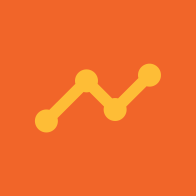
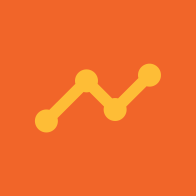

In [21]:
from IPython.core.display import display, HTML

page = !curl localhost:6006
page = '\n'.join(page)

display(HTML(page))

## Stop

### Constants and Variables

First of all, look at this python example, it simply creates a variable x with the value of 10, then, creates y with the sum of x and 5.

```python
x = 10
y = x + 5
print(y) # 15
```

The tensorflow equivalent is:

In [18]:
x = tf.constant(10, name='x')
y = tf.Variable(x + 5, name='y')

# another way
# v = tf.constant(5)
# x = tf.constant(10)
# y = x + v # in this case y is a Tensor, not a tf.Variable

print(x, y)

Tensor("x:0", shape=(), dtype=int32) <tf.Variable 'y:0' shape=() dtype=int32_ref>


As seen, it doesn't output 15, but a function to compute the result. To compute the result, it's necessary to create some new objects.

In [19]:
# Initializes the tf.Variable elements (not needed when there is only Tensors)
model = tf.global_variables_initializer()

# Se
with tf.Session() as session:
    session.run(model)
    print(session.run(y))

15


The `tf.global_variables_initializer` is used to initialize tf.Variable object, but isn't necessary for Tensor objects.

The `tf.Session` runs the graph created with the operations. It's a closeable object.

In [20]:
x = tf.constant([[10, 20], [30, 40]], name='x')
y = tf.Variable(x + 5, name='y')


with tf.Session() as session:
    session.run(tf.global_variables_initializer()) # inlined global_variables_initializer
    print(session.run(y))

[[15 25]
 [35 45]]


Example of function

$5x^2-3x+15$

In [21]:

x = tf.constant(np.arange(-8, 9))

a = tf.Variable(5 * x**2)
b = tf.Variable(3 * x)
c = tf.constant(15, dtype=tf.int64)
y = tf.Variable(a - b + c)
# y = tf.Variable(5 * x ** 2 - 3 * x + 15) # in a single declaration

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print(session.run(y))

[359 281 213 155 107  69  41  23  15  17  29  51  83 125 177 239 311]


It's possible to update variables in loops

In [22]:
x = tf.constant(0)

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    for i in range(5):
        x = x + 1
        print(session.run(x), end=' ')

1 2 3 4 5 

In [23]:
import tensorflow as tf

x = tf.constant(35, name='x')
print(x)
y = tf.Variable(x + 5, name='y')

with tf.Session() as session:
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("/tmp/basic", session.graph)
    model =  tf.global_variables_initializer()
    session.run(model)
    print(session.run(y))

Tensor("x_2:0", shape=(), dtype=int32)
40


### Arrays

Arrays are extensively used in tensorflow, almost all programs use it.

In [24]:
# download example image
!curl --output image.jpg -- 'https://learningtensorflow.com/images/MarshOrchid.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5748k  100 5748k    0     0   190k      0  0:00:30  0:00:30 --:--:--  280k


(5528, 3685, 3)


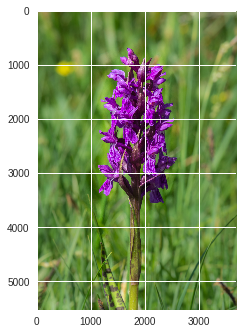

In [25]:
image_path = pathlib.Path('./image.jpg').absolute()

image = plt.imread(image_path)
print(image.shape)

plt.imshow(image)
plt.show()

Tensor("transpose:0", shape=(3685, 5528, 3), dtype=uint8)


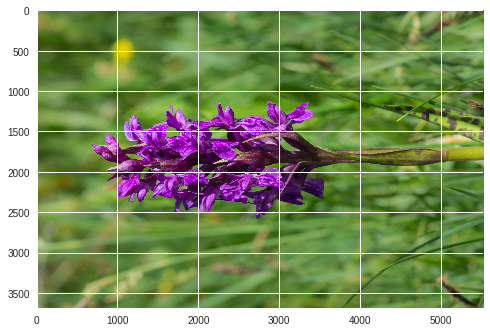

In [26]:
image_consttant = tf.constant(image)
transposed_image = tf.transpose(image_consttant, perm=[1, 0, 2])
print(transposed_image)

with tf.Session() as session:
	result = session.run(transposed_image)

plt.imshow(result)
plt.show()